This notebook demonstrates how the json files containing contact Jaccard similarity information can be used to cluster the backbones and select candidates

In [ ]:
import json, sys
from pathlib import Path
import shutil
import glob

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import scipy
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

from rele_binder_design.pdbutils import multiPDBLoader

# Initial clustering

In [57]:
glob_path = '/data1/groups/keatinglab/swans/binderDesign_relE/data/round_4_repeatNativeExtensions/6_clusterBackbonesByContacts/binderContactJaccardSimSparse_*.json'
paths = glob.glob(glob_path)
print(len(paths),paths[0])

sim_matrix = None
for path in paths:
    # print(path)
    with open(path,'r') as file:
        dump = json.load(file)
    if sim_matrix is None:
        n_binders = len(dump['binder_names'])
        sim_matrix = np.ones((n_binders,n_binders)) * -1
    sim_dict = dump['jaccard_similarity']
    for ((i,j),sim) in sim_dict:
        sim_matrix[i,j] = sim
        sim_matrix[j,i] = sim
        
pdb_names = [x.lstrip() for x in dump['binder_names']]

48 /data1/groups/keatinglab/swans/binderDesign_relE/data/round_4_repeatNativeExtensions/6_clusterBackbonesByContacts/binderContactJaccardSimSparse_17.json


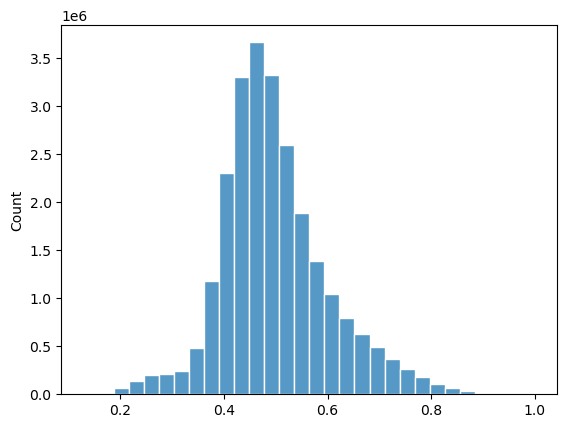

In [58]:
ax = sns.histplot(x=sim_matrix.flatten(),bins=30,edgecolor='white')
# plt.savefig('230512_contactpairsimilarity.png',dpi=300)

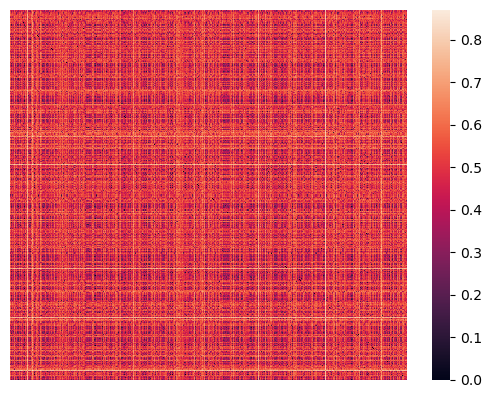

In [59]:
ax = sns.heatmap(data=1-sim_matrix,xticklabels=False,yticklabels=False)
# plt.savefig('230517_denovodesigns_distancematrix.png',dpi=300,bbox_inches='tight')

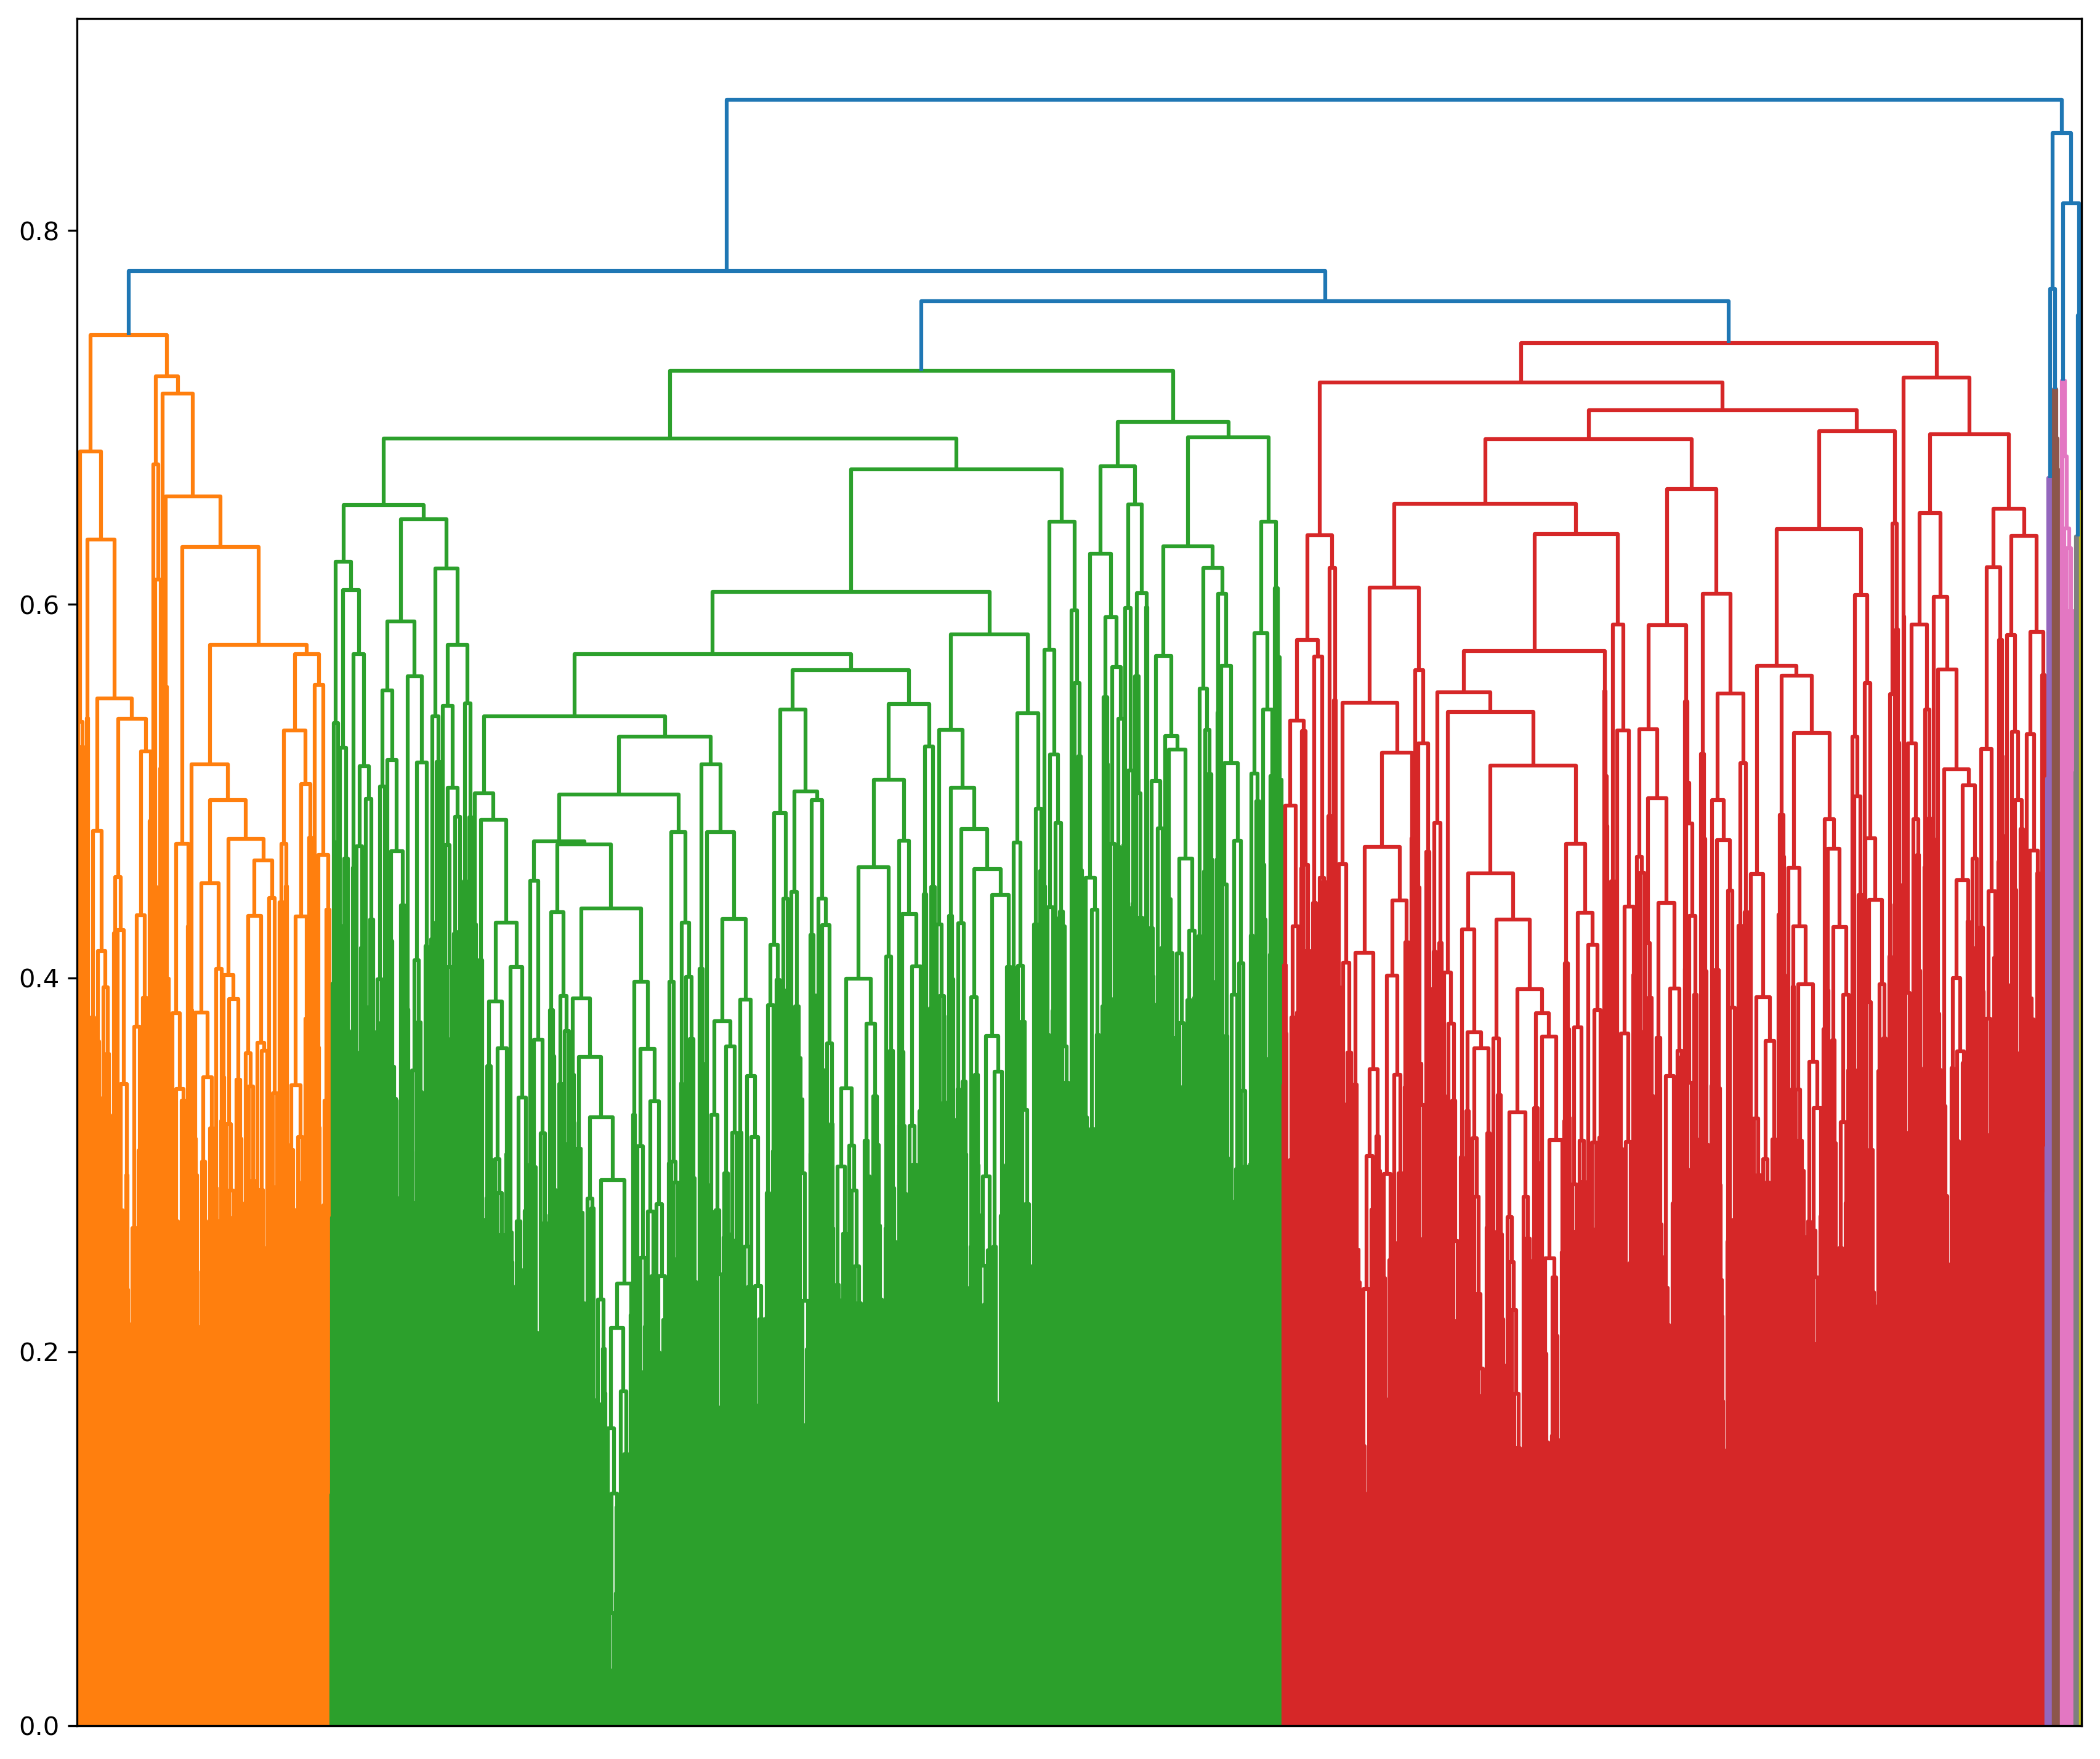

In [60]:
plt.figure(figsize=(14, 12), dpi=300)
condensed_d_matrix = scipy.spatial.distance.squareform(1 - sim_matrix)
Z = scipy.cluster.hierarchy.linkage(condensed_d_matrix,method='complete')
dn = scipy.cluster.hierarchy.dendrogram(Z,no_labels=True,color_threshold=0.75)#,count_sort='descending')
# plt.show()
# plt.savefig('230512_denovodesigns_contactpairdistance_dendogram_thresh0.95.png',dpi=300)

In [63]:
condensed_d_matrix = scipy.spatial.distance.squareform(1 - sim_matrix)
Z = scipy.cluster.hierarchy.linkage(condensed_d_matrix,method='complete')
clusters = scipy.cluster.hierarchy.fcluster(Z, t=0.75, criterion='distance')#, depth=2, R=None, monocrit=None)
dendogram_df = pd.DataFrame({'pdb_name':pdb_names,'cluster':clusters})
dendogram_df['pdb_name']
# dendogram_df = dendogram_df.sort_values(by='pdb_names')
dendogram_df

,pdb_name,cluster
0,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,2
1,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,3
2,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,3
3,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,3
4,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,1
...,...,...
4995,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,3
4996,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,3
4997,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,1
4998,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,2


In [64]:
dendogram_df.groupby('cluster').size().reset_index()

,cluster,0
0,1,634
1,2,2374
2,3,1903
3,4,18
4,5,20
5,6,34
6,7,14
7,8,3


In [65]:
sample_df = dendogram_df[dendogram_df['cluster']!=8].groupby('cluster').sample(10,random_state=42)
sample_df = pd.concat([sample_df,dendogram_df[dendogram_df['cluster']==8]])
sample_df

,pdb_name,cluster
3164,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,1
1909,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,1
1646,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,1
2795,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,1
4258,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,1
...,...,...
4385,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,7
3670,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,7
1584,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,8
2242,seed-4FXE-ARG81-relax-noHyd-48-66__0_connector...,8


In [71]:
path = 'relBhelix_1seedextensions_cluster0.75sampled_list.txt'
with open(path,'w') as file:
    for i,row in sample_df.iterrows():
        file.write(row['pdb_name']+'\n')

In [68]:
dendogram_df.groupby('cluster').ngroups

8

In [73]:
multipdbpath = '/data1/groups/keatinglab/swans/binderDesign_relE/data/round_4_repeatNativeExtensions/4_connectFragments_relBhelix-hotspotseeds_8resConnectors/fusedDB.pdb'
with multiPDBLoader(multipdbpath) as reader:
    reader.copyToNewMultiPDB(set(sample_df['pdb_name']),'relBhelix_1seedextensions_cluster0.75sampled.pdb')

Scanning multi-PDB file...
Scanned the file in 1.068 s and found 28781 structures
